In [5]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim

### Download data

In [31]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
12,2020-02-11,0,0,0


In [32]:
df['confirmed'].max()

5049

### Prep data

In [12]:
cnf = np.array(df.confirmed)
# data to be prepped in the form of seq_len, batch, num_inputs. so 3, 1, 1
dl = len(cnf) - 3 # dataset length
ip = torch.tensor(np.array([cnf[:-3], cnf[1:-2], cnf[2:-1]]).reshape(dl, 3, 1, 1), dtype=torch.float32)
op = torch.tensor(np.array(cnf[3:]), dtype=torch.float32)

### Define RNN

In [33]:
model = tnn.RNN(input_size=1, hidden_size=1)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=0.1)

### Train

Loss: 1.7103711502652885e-10
Loss: 8.491459618786834e-11
Loss: 0.9999340772628784
Loss: 0.999934732913971
Loss: 0.9999352693557739
Loss: 0.9999357461929321
Loss: 0.9999361634254456
Loss: 0.9999365210533142
Loss: 0.9999368786811829
Loss: 0.9999372363090515
Loss: 0.9999469518661499
Loss: 0.9999979138374329
Loss: 0.9999979734420776
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 1.0
Loss: 0.0
Loss: 441.0
Loss: 1.0
Loss: 0.0
Loss: 4.0
Loss: 16.000070571899414
Loss: 64.00009155273438
Loss: 196.00083923339844
Loss: 49.00041961669922
Loss: 81.00054168701172
Loss: 81.00054168701172
Loss: 100.00059509277344
Loss: 81.00054168701172
Loss: 169.0007781982422
Loss: 361.0011291503906
Loss: 576.001220703125
Loss: 676.0000610351562
Loss: 3249.000244140625
Loss: 5929.0
Loss: 4624.0
Loss: 8649.0
Loss: 5329.0
Loss: 7225.0
Loss: 5184.0
Loss: 23104.0
Loss: 18225.0
Loss: 14161.0
Loss: 34596.0

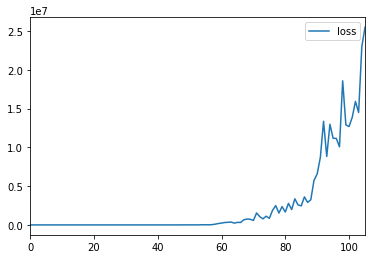

In [40]:
loss_vals = []
# h = torch.tensor(np.array([0]).reshape(1, 1, 1), dtype=torch.float32)
for i in range(dl):
    pred, _ = model(ip[i%dl])
    loss = loss_fn(pred, op[i%dl])

    loss_vals.append(loss.item())
    print("Loss:", loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

In [35]:
test_in = torch.tensor(
    np.array([10, 20, 30]).reshape(3, 1, 1),
    dtype=torch.float32
)
out, _ = model(test_in)
print(out)

tensor([[[1.]],

        [[1.]],

        [[1.]]], grad_fn=<StackBackward>)
